In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

# Load Data

In [3]:
tourney_data = pd.read_csv("../data/processed/tourney_data.csv")

# Model Building

In [4]:
# define log-loss scoring
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, GroupKFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

In [22]:
features1 = [
       'location', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d',
       'T2_win_ratio_14d', 'T1_seed', 'T2_seed', 'SeedDiff', 'T1_Rk',
       'T1_AdjEM', 'T1_AdjO', 'T1_Strength of Schedule_AdjD', 'T1_NCSOS_AdjT',
       'T2_Rk', 'T2_AdjEM', 'T2_AdjO', 'T2_Strength of Schedule_AdjD',
       'T2_NCSOS_AdjT'
]

features = [
    'T1_win_ratio_14d',
    'T2_win_ratio_14d', 'T1_seed', 'T2_seed', 'SeedDiff', 'T1_Rk',
    'T1_AdjEM', 'T1_AdjO', 'T1_Strength of Schedule_AdjD', 'T1_NCSOS_AdjT',
    'T2_Rk', 'T2_AdjEM', 'T2_AdjO', 'T2_Strength of Schedule_AdjD',
    'T2_NCSOS_AdjT'
]

df = tourney_data.dropna(how='any')

X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)

# split training and testing:
random_state = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=random_state)

In [7]:
def print_score(m):
    res = {
        "train log loss":log_loss(y_train, m.predict(X_train)), 
        "val log loss" : log_loss(y_val, m.predict(X_val)),
        "training r^2" : m.score(X_train, y_train), 
        "validation r^2" : m.score(X_val, y_val)
        }
    if hasattr(m, 'oob_score_'): 
        res['oob score'] = m.oob_score_
    for label, val in res.items(): 
        print(label + ": ", val)

## Random Forest
Just to get warmed up again.

In [23]:
random_state = 1
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)

%time model.fit(X_train, y_train)

print_score(model)

Wall time: 254 ms
train log loss:  0.1347788507152001
val log loss:  0.6361127728150276
training r^2:  0.9023252880093426
validation r^2:  0.2686735465116278


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


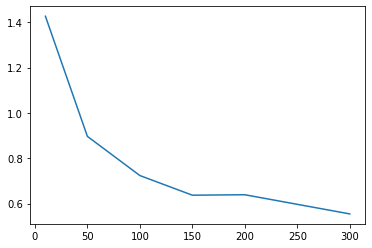

In [25]:
n_trees = [10, 50, 100, 150, 200, 300]
val_log_loss = []
for n in n_trees:
    model = RandomForestRegressor(
        n_estimators=n, n_jobs=-1, oob_score=True, random_state=random_state
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(n_trees, val_log_loss)

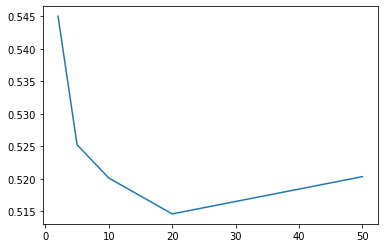

In [26]:
params = dict(
    n_jobs=-1,
    oob_score=True, 
    n_estimators=300,
)

min_samples_leaf = [2, 5, 10, 20, 50]
val_log_loss = []
for msl in min_samples_leaf:
    model = RandomForestRegressor(  
        min_samples_leaf=msl,
        **params
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(min_samples_leaf, val_log_loss)

In [27]:
val, idx = min((val, idx) for (idx, val) in enumerate(val_log_loss))
params['min_samples_leaf'] = min_samples_leaf[idx]

{'n_jobs': -1, 'oob_score': True, 'n_estimators': 300, 'min_samples_leaf': 20}


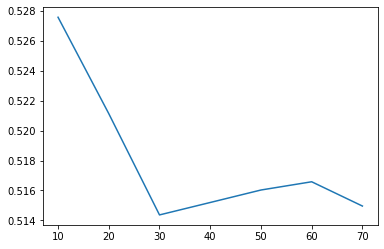

In [28]:
max_leaf_nodes = [10, 20, 30, 40, 50, 60, 70]
print(params)

val_log_loss = []
for m in max_leaf_nodes:
    model = RandomForestRegressor(
     max_leaf_nodes=m, **params
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(max_leaf_nodes, val_log_loss)

In [29]:
val, idx = min((val, idx) for (idx, val) in enumerate(val_log_loss))
params['max_leaf_nodes'] = max_leaf_nodes[idx]
print("Max leaf nodes: ", max_leaf_nodes[idx])

Max leaf nodes:  30


In [30]:
print(params)
model = RandomForestRegressor(
     **params
    )
model.fit(X_train, y_train)
print_score(model)

{'n_jobs': -1, 'oob_score': True, 'n_estimators': 300, 'min_samples_leaf': 20, 'max_leaf_nodes': 30}
train log loss:  0.39737969403171497
val log loss:  0.5180959571023522
training r^2:  0.48811784884252657
validation r^2:  0.30020298083886854
oob score:  0.3458429261007604


## CV Pipe

In [31]:
from sklearn.model_selection import LeaveOneGroupOut
def cv_score(m, X_test_, y_test_, print_=True):
    res = log_loss(y_test_, m.predict(X_test_))
    if print_: print(f"Val log loss: {res}")
    return res

def leave_one_out_CV(estimater, params, folds, df, features):
    X = df[features].copy()
    y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
    groups = df['Season'].values - 2003

    # split training and testing:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)


    cv_res = {}
    group_kfold = LeaveOneGroupOut()
    groups_ = groups[X_train.index]

    for i in range(folds):
        cv_res[i] = []
        for train_index, test_index in group_kfold.split(X_train.values, y_train, groups_):
            X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_, y_test_ = y_train[train_index], y_train[test_index]

            if hasattr(estimater, "random_state"):
                params['random_state'] = i

            m = estimater(**params)
            m.fit(X_train_, y_train_)
            cv_res[i].append(cv_score(m, X_test_, y_test_, print_=False))
        print(f"Fold {i} Log Loss: {np.mean(cv_res[i])}")

    cv_results = [np.mean(vals) for i, vals in cv_res.items()]
    print("CV Fold Results", cv_results)
    print("Mean CV Log Loss: ", np.mean(cv_results))

In [32]:
df = tourney_data.dropna(how='any').reset_index(drop=True)

leave_one_out_CV(estimater=RandomForestRegressor, params=params, 
                 folds=3, df=df, features=features)

Fold 0 Log Loss: 0.5027941549995318
Fold 1 Log Loss: 0.5044081480169045
Fold 2 Log Loss: 0.5031011270275108
CV Fold Results [0.5027941549995318, 0.5044081480169045, 0.5031011270275108]
Mean CV Log Loss:  0.5034344766813157


In [42]:
from sklearn.model_selection import GridSearchCV

def custom_scoring(estimator, X, y):
    return log_loss(y, estimator.predict(X))

# use grid search CV to hyper parameter tune properly:
df = tourney_data.dropna(how='any').reset_index().copy()
X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
groups = df['Season'].values - 2003

# split training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)


cv_res = {}
logo = LeaveOneGroupOut()
groups_ = groups[X_train.index]

param_grid = {
    'n_estimators' : [10, 50, 100, 150, 200, 300],
    'min_samples_leaf' : [2, 5, 10, 20, 50],
    'max_leaf_nodes' : [10, 20, 30, 40, 50, 60, 70]
}


gs_cv = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    scoring=None,
    n_jobs=-1,
    cv=logo.split(X_train, y_train, groups_),
    verbose=True
)

gs_cv.fit(X_train, y_train)

Fitting 17 folds for each of 210 candidates, totalling 3570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2474 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3224 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3570 out of 3570 | elapsed:  4.1min finished


GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x00000203B038F5C8>,
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                 

In [44]:
best_model = gs_cv.best_estimator_

print(f"Best params: {gs_cv.best_params_}")
print_score(best_model)

Best params: {'max_leaf_nodes': 60, 'min_samples_leaf': 20, 'n_estimators': 50}
train log loss:  0.4096277636688148
val log loss:  0.4833327730559077
training r^2:  0.47146666829422823
validation r^2:  0.3487239394737309


# Linear Models

In [89]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

def custom_scoring(estimator, X, y):
    return log_loss(y, estimator.predict(X))

ridge = linear_model.Ridge()

# use grid search CV to hyper parameter tune properly:
df = tourney_data.dropna(how='any').reset_index().copy()
X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
groups = df['Season'].values - 2003

# split training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

groups = groups[X_train.index]

logo = LeaveOneGroupOut()

cv_score = cross_val_score(
        estimator=ridge,
        X=X_train,
        y=y_train,
        groups=groups,
#         scoring = custom_scoring,
        cv = logo.split(X_train, y_train, groups),
        n_jobs=-1,
        verbose=0,
    )

In [90]:
np.mean(cv_score)

0.3467008596749174

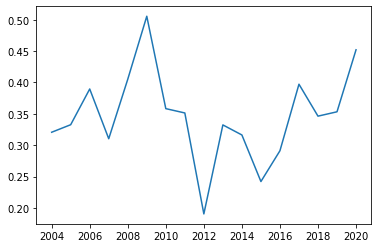

In [91]:
plt.plot(range(2004, 2021), cv_score)